In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/American\ express

/content/drive/My Drive/Colab Notebooks/American express


In [0]:
import pandas as pd

In [0]:
dfcampaign_data = pd.read_csv('Train/campaign_data.csv',parse_dates=[2,3])
dfcoupon_item_mapping = pd.read_csv('Train/coupon_item_mapping.csv')
dfcustomer_demographics = pd.read_csv('Train/customer_demographics.csv')
dfcustomer_transaction_data = pd.read_csv('Train/customer_transaction_data.csv',parse_dates=[0])
dfitem_data = pd.read_csv('Train/item_data.csv')
dftrain = pd.read_csv('Train/train.csv')

In [0]:
# Grouping columnms

In [0]:
groupdb = dfcustomer_transaction_data.groupby(['customer_id','item_id']).agg(['min', 'mean' ,'max'])
groupdb.columns = ['quantity min','quantity mean','quantity max'
                   ,'selling_price min','selling_price mean','selling_price max' 
                   ,'other_discount min','other_discount mean','other_discount max',
                  'coupon_discount min','coupon_discount mean','coupon_discount max',]
groupdb = groupdb.reset_index()
newgroup = groupdb.merge(dfcoupon_item_mapping, on=['item_id'],how='outer')
newgroup.dropna(inplace= True)

In [7]:
newgroup.head()

,customer_id,item_id,quantity min,quantity mean,quantity max,selling_price min,selling_price mean,selling_price max,other_discount min,other_discount mean,other_discount max,coupon_discount min,coupon_discount mean,coupon_discount max,coupon_id
18,1.0,4796,1.0,1.0,1.0,106.5,106.5,106.5,0.0,0.0,0.0,0.0,0.0,0.0,21.0
19,1.0,4796,1.0,1.0,1.0,106.5,106.5,106.5,0.0,0.0,0.0,0.0,0.0,0.0,30.0
20,4.0,4796,1.0,1.0,1.0,106.5,106.5,106.5,0.0,0.0,0.0,0.0,0.0,0.0,21.0
21,4.0,4796,1.0,1.0,1.0,106.5,106.5,106.5,0.0,0.0,0.0,0.0,0.0,0.0,30.0
22,7.0,4796,1.0,1.0,1.0,106.5,106.5,106.5,0.0,0.0,0.0,0.0,0.0,0.0,21.0


In [0]:
#Train data

In [0]:
finaldb = newgroup.merge(dftrain,on = ['customer_id','coupon_id'],how='outer')
finaldb.dropna(inplace=True)
finaldb2 =finaldb.merge(dfcampaign_data, on='campaign_id',how='left')
finaldb3 = finaldb2.merge(dfcustomer_demographics,on='customer_id',how='left')
finaldb4 = finaldb3.merge(dfitem_data,on='item_id',how='left')

In [0]:
# subtracting dates


In [0]:
finaldb4['coupdays'] = finaldb4['end_date']-finaldb4['start_date']
finaldb4['coupdays'] =finaldb4['coupdays'].dt.days

In [11]:
finaldb4.head()

,customer_id,item_id,quantity min,quantity mean,quantity max,selling_price min,selling_price mean,selling_price max,other_discount min,other_discount mean,other_discount max,coupon_discount min,coupon_discount mean,coupon_discount max,coupon_id,id,campaign_id,redemption_status,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket,brand,brand_type,category,coupdays
0,162.0,4796.0,1.0,1.0,1.0,106.50,106.500000,106.50,0.00,0.000000,0.00,0.00,0.000,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,26-35,NaN,0.0,2,NaN,5.0,278,Established,Grocery,-12
1,162.0,14215.0,1.0,2.0,3.0,35.62,131.162222,212.65,-35.26,-10.606667,0.00,0.00,0.000,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,26-35,NaN,0.0,2,NaN,5.0,278,Established,Grocery,-12
2,162.0,19632.0,1.0,1.0,1.0,59.49,73.380000,78.01,-18.52,-4.630000,0.00,-35.62,-8.905,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,26-35,NaN,0.0,2,NaN,5.0,278,Established,Grocery,-12
3,162.0,25721.0,1.0,1.0,1.0,59.49,71.420000,83.35,-64.83,-52.895000,-40.96,0.00,0.000,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,26-35,NaN,0.0,2,NaN,5.0,278,Established,Grocery,-12
4,162.0,28133.0,1.0,1.0,1.0,21.37,21.370000,21.37,-10.33,-10.330000,-10.33,-14.25,-14.250,-14.25,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,26-35,NaN,0.0,2,NaN,5.0,1709,Established,Grocery,-12


In [12]:
percent_missing = finaldb4.isnull().sum() * 100 / len(finaldb4)
missing_value_df = pd.DataFrame({'column_name': finaldb4.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.head()

,column_name,percent_missing
customer_id,customer_id,0.0
brand_type,brand_type,0.0
brand,brand,0.0
end_date,end_date,0.0
start_date,start_date,0.0


In [0]:
columnstodrop = list(missing_value_df[missing_value_df['percent_missing']>35]['column_name'])

In [0]:
finaldb5 = finaldb4.drop(columnstodrop,axis=1)

In [15]:
finaldb5.head()

,customer_id,item_id,quantity min,quantity mean,quantity max,selling_price min,selling_price mean,selling_price max,other_discount min,other_discount mean,other_discount max,coupon_discount min,coupon_discount mean,coupon_discount max,coupon_id,id,campaign_id,redemption_status,campaign_type,start_date,end_date,brand,brand_type,category,coupdays
0,162.0,4796.0,1.0,1.0,1.0,106.50,106.500000,106.50,0.00,0.000000,0.00,0.00,0.000,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,278,Established,Grocery,-12
1,162.0,14215.0,1.0,2.0,3.0,35.62,131.162222,212.65,-35.26,-10.606667,0.00,0.00,0.000,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,278,Established,Grocery,-12
2,162.0,19632.0,1.0,1.0,1.0,59.49,73.380000,78.01,-18.52,-4.630000,0.00,-35.62,-8.905,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,278,Established,Grocery,-12
3,162.0,25721.0,1.0,1.0,1.0,59.49,71.420000,83.35,-64.83,-52.895000,-40.96,0.00,0.000,0.00,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,278,Established,Grocery,-12
4,162.0,28133.0,1.0,1.0,1.0,21.37,21.370000,21.37,-10.33,-10.330000,-10.33,-14.25,-14.250,-14.25,21.0,10614.0,13.0,1.0,X,2013-05-19,2013-05-07,1709,Established,Grocery,-12


In [0]:
finaldb5.drop(['start_date','end_date'],axis=1,inplace=True)

In [0]:
finaldb5 = pd.concat((finaldb5,pd.get_dummies(finaldb5[['campaign_type','brand_type','category']])),axis=1)
finaldb5.drop(['brand_type','category','campaign_type','campaign_id','coupon_id','item_id','customer_id'],axis=1,inplace=True)

In [18]:
###Over sampling
'''
count_class_0, count_class_1 = finaldb5['redemption_status'].value_counts()
dfa = finaldb5[finaldb5.redemption_status==0]
dfb = finaldb5[finaldb5.redemption_status==1]
df_class_0_under = dfb.sample(count_class_0,replace =True)
df_test_under = pd.concat([df_class_0_under, dfa], axis=0)
finaldb5 =df_test_under
'''

"\ncount_class_0, count_class_1 = finaldb5['redemption_status'].value_counts()\ndfa = finaldb5[finaldb5.redemption_status==0]\ndfb = finaldb5[finaldb5.redemption_status==1]\ndf_class_0_under = dfb.sample(count_class_0,replace =True)\ndf_test_under = pd.concat([df_class_0_under, dfa], axis=0)\nfinaldb5 =df_test_under\n"

In [0]:
### Under sampling
count_class_0, count_class_1 = finaldb5['redemption_status'].value_counts()
dfa = finaldb5[finaldb5['redemption_status']==0]
dfb=finaldb5[finaldb5['redemption_status']==1]
df_class_0_under = dfa.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, dfb], axis=0)
finaldb5 =df_test_under

In [20]:
finaldb5.shape

(14896, 36)

In [0]:
ids = finaldb5.pop('id')
y = finaldb5.pop('redemption_status')
X= finaldb5

In [0]:
### Final Test Data

In [0]:
dftest = pd.read_csv('test_QyjYwdj.csv')

In [0]:
finaldbTest = newgroup.merge(dftest,on = ['customer_id','coupon_id'],how='outer')
finaldbTest.dropna(inplace=True)
finaldbTest2 =finaldbTest.merge(dfcampaign_data, on='campaign_id',how='left')
finaldbTest3 = finaldbTest2.merge(dfcustomer_demographics,on='customer_id',how='left')
finaldbTest4 = finaldbTest3.merge(dfitem_data,on='item_id',how='left')

In [0]:
finaldbTest4['coupdays'] = finaldbTest4['end_date']-finaldbTest4['start_date']
finaldbTest4['coupdays'] =finaldbTest4['coupdays'].dt.days

In [0]:
finaldbTest5 = finaldbTest4.drop(columnstodrop,axis=1)
finaldbTest5.drop(['start_date','end_date'],axis=1,inplace=True)
finaldbTest5 = pd.concat((finaldbTest5,pd.get_dummies(finaldbTest5[['campaign_type','brand_type','category']])),axis=1)
finaldbTest5.drop(['brand_type','category','campaign_type','campaign_id','coupon_id','item_id','customer_id'],axis=1,inplace=True)

In [0]:
idsFinalTest = finaldbTest5.pop('id')
XFinalTest= finaldbTest5

In [0]:
##### END

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, stratify =y)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaleddata = scaler.fit_transform(X_train)

In [0]:
###Test data

In [0]:
scaledtestdata = scaler.transform(X_test)

In [0]:
#### Final Test data

In [0]:
scaledFinalTest = scaler.transform(XFinalTest)

In [0]:
### Applying PCA

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [37]:
pca = PCA(svd_solver='randomized', random_state=0)
pca.fit(scaleddata)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='randomized', tol=0.0, whiten=False)

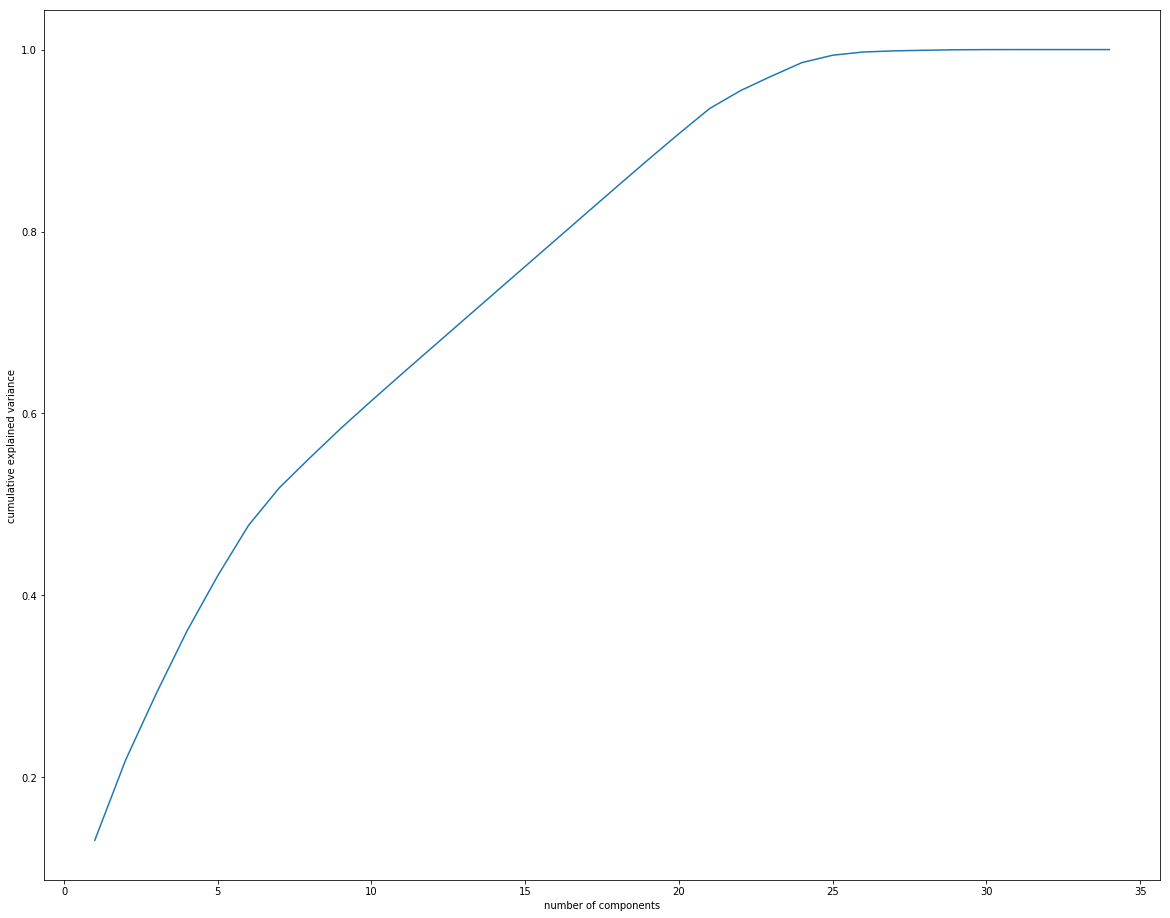

In [38]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (20,16))
plt.plot(range(1,35),np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

In [0]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=26)

In [40]:
X_train_pca = pca_final.fit_transform(scaleddata)
X_train_pca.shape

(13406, 26)

In [0]:
### model

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def roc(y_true, y_pred):
   return metrics.roc_auc_score(y_true, pd.Series(y_pred))
  

In [44]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer with dropout
# Take average of input + output for units/output_dim param in Dense
# input_dim is necessary for the first layer as it was just initialized
classifier.add(Dense(25, input_dim = X_train_pca.shape[1], kernel_initializer = 'glorot_uniform', activation = 'relu' ))
classifier.add(Dropout(p = 0.1))

# Adding the second hidden layer with dropout
# doesn't need the input_dim params
# kernel_initializer updates weights
# activation function - rectifier
classifier.add(Dense(15, kernel_initializer = 'glorot_uniform', activation = 'relu' ))
classifier.add(Dropout(p = 0.1))

# Adding the output layer
# dependent variable with more than two categories (3), output_dim needs to change (e.g. 3), activation function - sufmax
classifier.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid' ))

# Compiling the ANN - applying Stochastic Gradient Descent to whole ANN
# Several different SGD algorithms
# mathematical details based on the loss function
# binary_crossentropy, categorical_cross_entropy
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m])

# Fitting the ANN to the Training Set
# X_train, y_train, Batch size, Epochs (whole training set)
classifier.fit(X_train_pca, y_train, batch_size = 10, nb_epoch = 100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
13406/13406 [==============================] - 2s 181us/step - loss: 0.6310 - f1_m: 0.6242
Epoch 2/100
13406/13406 [==============================] - 2s 139us/step - loss: 0.6059 - f1_m: 0.6449
Epoch 3/100
13406/13406 [==============================] - 2s 126us/step - loss: 0.5996 - f1_m: 0.6411
Epoch 4/100
13406/13406 [==============================] - 2s 135us/step - loss: 0.5980 - f1_m: 0.6454
Epoch 5/100
13406/13406 [==============================] - 2s 134us/step - loss: 0.5953 - f1_m: 0.6456
Epoch 6/100
13406/13406 [==============================] - 2s 133us/step - loss: 0.5920 - f1_m: 0.6485
Epoch 7/100
13406/13406 [==============================] - 2s 124us/step - loss: 0.5890 - f1_m: 0.6528
Epoch 8/100
13406/13406 [==============================] - 2s 121us/step - loss: 0.5886 - f1_m: 0.6500
Epoch 9/100
13406/13406 [==============================] - 2s 125us/step - loss: 0.5880 - f1_m: 0.6527
Epoch 10/100
13406/13406 [==============================] - 2s 126us/step

In [0]:
lrmodel = classifier
train_pred_1 = lrmodel.predict(X_train_pca)

In [0]:
train_pred = [1 if x>0.5 else 0 for x in train_pred_1]

In [47]:
accuracy_score = metrics.accuracy_score(y_train, train_pred)
precision_score = metrics.precision_score(y_train, train_pred)
recall_score = metrics.recall_score(y_train, train_pred)
f1_score = metrics.f1_score(y_train, train_pred)
roc = metrics.roc_auc_score(y_train, train_pred)
# print(accuracy_score, precision_score, recall_score, f1_score)


# write the scores into the output file as a dictionary
# this code is already written for you
d = {'recall_score': recall_score,
    'f1_score': f1_score,
    'accuracy_score': accuracy_score,
	'precision_score': precision_score,
    'ROC' :roc}
for key,val in d.items():
    print(key,'  :  ',val)

recall_score   :   0.7402655527375802
f1_score   :   0.7066362859584165
accuracy_score   :   0.6926749216768611
precision_score   :   0.6759297098487944
ROC   :   0.6926749216768611


In [0]:
### model end

In [0]:
### Checking model on test data

In [50]:
X_test_pca = pca_final.transform(scaledtestdata)
X_test_pca.shape

(1490, 26)

In [0]:
test_pred_1 = lrmodel.predict(X_test_pca)
test_pred = [1 if x>0.5 else 0 for x in test_pred_1]

In [52]:
accuracy_score = metrics.accuracy_score(y_test, test_pred)
precision_score = metrics.precision_score(y_test, test_pred)
recall_score = metrics.recall_score(y_test, test_pred)
f1_score = metrics.f1_score(y_test, test_pred)
roc = metrics.roc_auc_score(y_test, test_pred)
# print(accuracy_score, precision_score, recall_score, f1_score)


# write the scores into the output file as a dictionary
# this code is already written for you
d = {'recall_score': recall_score,
    'f1_score': f1_score,
    'accuracy_score': accuracy_score,
	'precision_score': precision_score,
    'ROC' :roc}
for key,val in d.items():
    print(key,'  :  ',val)

recall_score   :   0.6899328859060403
f1_score   :   0.664941785252264
accuracy_score   :   0.6523489932885906
precision_score   :   0.6416978776529338
ROC   :   0.6523489932885906


In [0]:
#### Checking model on final test data

In [54]:
X_test_pca_final = pca_final.transform(scaledFinalTest)
X_test_pca_final.shape


(65008, 26)

In [0]:
test_pred_final_1 = lrmodel.predict(X_test_pca_final)

In [0]:
test_pred_final = [1 if x>0.5 else 0 for x in test_pred_final_1]

In [0]:
### Creating data frame submission

In [0]:
dfcheck  =  pd.DataFrame(test_pred_final,idsFinalTest)

In [0]:
dfcheck2 = dfcheck.reset_index()

In [0]:
dfcheck2.columns = ['id','redemption_status']

In [0]:
dfcheck3 = dfcheck2.drop_duplicates()

In [0]:
dfcheck4 = dfcheck3[dfcheck3['redemption_status']==1]

In [63]:
dfsubmission = dftest.merge(dfcheck4,on='id',how='left')
dfsubmission = dfsubmission.fillna(0)
dfsubmission.drop(['campaign_id','coupon_id','customer_id'],axis=1,inplace=True)
dfsubmission.head()

,id,redemption_status
0,3,1.0
1,4,0.0
2,5,0.0
3,8,0.0
4,10,0.0


In [0]:
dfsubmission.to_csv('submission.csv')

In [0]:
from google.colab import files
files.download('submission.csv') 